In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot
import numpy as np


In [12]:
df = pd.read_csv('Recoded regular and hard drug.csv')

In [13]:
#Split dataset into training set and test set

cols = ['HEALTH','DIFFTHINK','IRMARITSTAT','MILFAMILY','WRKRSNJOB',
       'IMOTHER', 'MOVSINPYR2', 'DIFFWALK', 'IREDUHIGHST2', 'MILSPOUSE',
       'WRKDPSTYR', 'IFATHER', 'SEXATRACT', 'DIFFDRESS', 'WRKSTATWK2',
       'IRWRKSTAT', 'POVERTY3', 'MILSTAT', 'DIFFHEAR', 'IRSEX', 'EDUENROLL',
       'WRKHADJOB', 'EDFAM18', 'DIFFSEE', 'SERVICE', 'SEXIDENT',
       'DIFFERAND','PDEN10','NOMARR2','NEWRACE2','SEXRACE','INCOME','COUTYP4']


In [14]:
print(df['SEXAGE'].unique())
print(df['SEXIDENT'].unique())
print(df['SEXRACE'].unique())


[1 5 2 4 3]
[0 1 2 3]
[1 5 2 6 7 4 3]


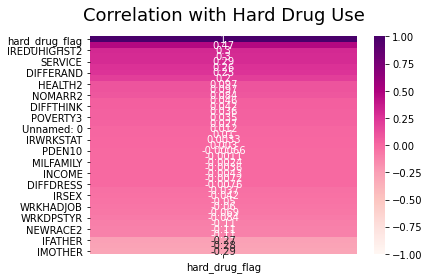

In [15]:
#plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['hard_drug_flag']].sort_values(by='hard_drug_flag', ascending=False), vmin=-1, vmax=1, annot=True, cmap='RdPu')
heatmap.set_title('Correlation with Hard Drug Use', fontdict={'fontsize':18}, pad=16);

# Test of Difference Between Cohorts

## Initial Data Exploration

In [16]:
from matplotlib import pyplot

data_ex = df[['SEXAGE','hard_drug_flag']]
data_ex['obs'] = pd.Series([1 for x in range(len(data_ex.index))])

data_agg = data_ex.groupby(['SEXAGE','hard_drug_flag'])['obs'].sum().reset_index()

<ipython-input-16-45d649dc16ca>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ex['obs'] = pd.Series([1 for x in range(len(data_ex.index))])


In [17]:
#data_agg.head()
pos = data_agg[data_agg['hard_drug_flag']==1]
neg = data_agg[data_agg['hard_drug_flag']==0]
labels = pos[['SEXAGE']].values.tolist()

posplot = pos['obs'].values.tolist()
negplot = neg['obs'].values.tolist()
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars


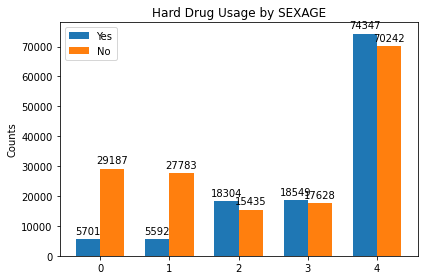

In [18]:
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, posplot, width, label='Yes')
rects2 = ax.bar(x + width/2, negplot, width, label='No')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Counts')
ax.set_title('Hard Drug Usage by SEXAGE')

ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

Based on the above chart, it does look like there is a signficant difference in the drug use behavior between cohorts.  Next step is to validate with Chi-Square.

## Test of Difference with Chi-Square

Chi-Square was chosen in this case because our data is categorical in nature.  We run the test to see if the null hypothesis is true (that the cohorts have similar behavior).

In [19]:
from sklearn import feature_selection
chi2, p = feature_selection.chi2(df[['SEXAGE','SEXRACE']],df['hard_drug_flag'])


In [20]:
Chi2 = pd.DataFrame(['SEXAGE','SEXRACE'],columns = ['Features'])
Chi2['Chi2'] = chi2
Chi2['p-val'] = p

print(Chi2)

  Features          Chi2  p-val
0   SEXAGE  11090.480798    0.0
1  SEXRACE   5228.531629    0.0


The Chi-Square test rejects the null hypothesis with a pval < 0.05, and a high Chi2 value.  We will use SEXAGE to base the cohorts on.  Next step is to do the post-hoc TUKEY analysis to see where the specific differences lie in between the cohorts.

# Post Hoc Analysis

In [21]:
#pip install scikit_posthocs

In [22]:
import scipy.stats as ss
import statsmodels.api as sa
import scikit_posthocs as sp
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [23]:
# perform Tukey's test
tukey = pairwise_tukeyhsd(endog=df['hard_drug_flag'],
                          groups=df['SEXAGE'],
                          alpha=0.05)

#display results
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2   0.0041 0.7547 -0.0057   0.014  False
     1      3   0.3791  0.001  0.3693  0.3889   True
     1      4   0.3493  0.001  0.3397   0.359   True
     1      5   0.3508  0.001  0.3431  0.3585   True
     2      3    0.375  0.001   0.365  0.3849   True
     2      4   0.3452  0.001  0.3354  0.3549   True
     2      5   0.3466  0.001  0.3388  0.3545   True
     3      4  -0.0298  0.001 -0.0395   -0.02   True
     3      5  -0.0283  0.001 -0.0361 -0.0205   True
     4      5   0.0015    0.9 -0.0061   0.009  False
----------------------------------------------------


According to the Tukey test, there is no significant difference between groups (1,2) and (4,5).  We can thus group these together to form the following cohorts: (1,2), 3, (4,5).

In [24]:
df_g12 = df[df['SEXAGE'] <= 2]
df_g3 = df[df['SEXAGE'] == 3]
df_g45 = df[df['SEXAGE'] >= 4]

df_g3.head()

,Unnamed: 0,HEALTH,DIFFTHINK,IRMARITSTAT,MILFAMILY,WRKRSNJOB,IMOTHER,MOVSINPYR2,DIFFWALK,IREDUHIGHST2,...,WRKDPSTWK,SEXAGE,SEXRACE,NEWRACE2,INCOME,PDEN10,COUTYP4,NOMARR2,reg_drug_flag,hard_drug_flag
5,5,3,0,0,0,4,0,4,2,9,...,2,3,7,5,1,1,1,0,1.0,0.0
6,6,2,0,1,0,0,0,4,2,8,...,1,3,5,7,2,2,2,0,1.0,0.0
36,36,3,0,0,0,1,0,2,2,7,...,2,3,3,2,1,2,2,0,1.0,1.0
38,38,2,0,0,0,4,0,2,2,9,...,2,3,5,7,4,1,1,0,1.0,1.0
40,40,1,0,0,0,0,0,2,2,11,...,1,3,1,1,1,1,1,0,1.0,1.0


# Random Forest Classifier - Hard Drugs

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn import metrics

In [26]:
#FOR HARD DRUGS
cols = ['HEALTH','DIFFTHINK','IRMARITSTAT','MILFAMILY','WRKRSNJOB',
       'IMOTHER', 'MOVSINPYR2', 'DIFFWALK', 'IREDUHIGHST2', 'MILSPOUSE',
       'WRKDPSTYR', 'IFATHER', 'SEXATRACT', 'DIFFDRESS', 'WRKSTATWK2',
       'IRWRKSTAT', 'POVERTY3', 'MILSTAT', 'DIFFHEAR', 'IRSEX', 'EDUENROLL',
       'WRKHADJOB', 'EDFAM18', 'DIFFSEE', 'SERVICE', 'SEXIDENT',
       'DIFFERAND','PDEN10','NOMARR2','NEWRACE2','SEXRACE','INCOME','COUTYP4']

xTrain, xTest, yTrain, yTest = train_test_split(df_g12[cols], df_g12['hard_drug_flag'], test_size = .3)

In [27]:
#Define the classification algorithm.  n_estimators = 100 is the default, this is the number of trees in the forest.
rfc_hard = RandomForestClassifier(n_estimators = 100, random_state = 0)
rfc_hard.fit(xTrain,yTrain)
rfc_hard_pred = rfc_hard.predict(xTest)
rfc_hard_probs = rfc_hard.predict_proba(xTest)
rfc_hard_score = rfc_hard.score(xTest,yTest)

<Figure size 216x216 with 0 Axes>

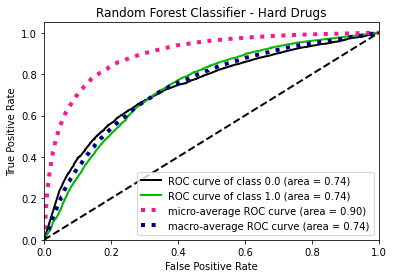

In [28]:
np.random.seed(10)
plt.figure(figsize=(3,3))
scikitplot.metrics.plot_roc(yTest, rfc_hard_probs, title = 'Random Forest Classifier - Hard Drugs')
plt.show()

In [29]:
#Print simple classification report.  Obviously this algorithm isnt very accurate with the data that was put into it.  More features should help.

from sklearn.metrics import classification_report
print(classification_report(yTest, rfc_hard_pred))


              precision    recall  f1-score   support

         0.0       0.85      0.95      0.90     17108
         1.0       0.37      0.14      0.20      3371

    accuracy                           0.82     20479
   macro avg       0.61      0.55      0.55     20479
weighted avg       0.77      0.82      0.78     20479



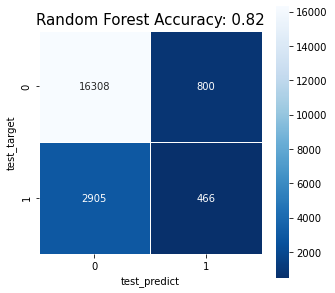

In [30]:
c_m = metrics.confusion_matrix(yTest, rfc_hard_pred)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
plt.figure(figsize=(5,5))
sns.heatmap(c_m, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues_r');
title = 'Random Forest Accuracy: {:.2f}'.format(rfc_hard_score)
plt.ylabel('test_target');
plt.xlabel('test_predict');
plt.title(title, size = 15);

# LOGISTIC REGRESSION - Hard Drugs

In [31]:
from sklearn.linear_model import LogisticRegression

#Define the classification algorithm.  n_estimators = 100 is the default, this is the number of trees in the forest.
logreg_hard = LogisticRegression(random_state = 0, max_iter=500)
logreg_hard.fit(xTrain,yTrain)
logreg_hard_pred = logreg_hard.predict(xTest)
logreg_hard_probs = logreg_hard.predict_proba(xTest)
logreg_hard_score = logreg_hard.score(xTest,yTest)


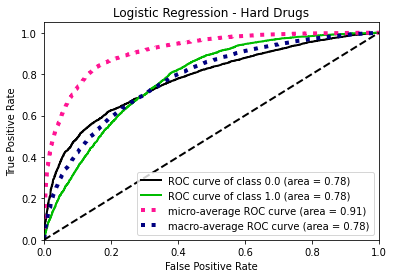

In [32]:
scikitplot.metrics.plot_roc(yTest, logreg_hard_probs, title = "Logistic Regression - Hard Drugs")
plt.show()

In [33]:
from sklearn.metrics import classification_report
print(classification_report(yTest, logreg_hard_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.99      0.91     17108
         1.0       0.56      0.09      0.15      3371

    accuracy                           0.84     20479
   macro avg       0.70      0.54      0.53     20479
weighted avg       0.80      0.84      0.79     20479



[[16882   226]
 [ 3084   287]]


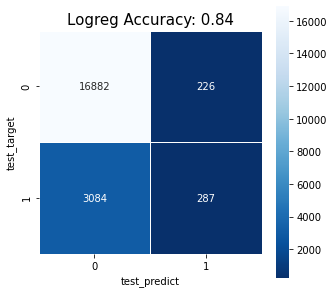

In [34]:
x = metrics.confusion_matrix(yTest, logreg_hard_pred)
print(x)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
plt.figure(figsize=(5,5))
sns.heatmap(x, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues_r');
plt.ylabel('test_target');
plt.xlabel('test_predict');
title = 'Logreg Accuracy: {:.2f}'.format(logreg_hard_score)
plt.title(title, size = 15);


# Naive Bayes

Not an appropriate predictor for some reason

# XGBoost

In [35]:
import xgboost as xgb

xgb_hard = xgb.XGBClassifier()
xgb_hard.fit(xTrain, yTrain)
xgb_hard_pred = xgb_hard.predict(xTest)
xgb_hard_probs = xgb_hard.predict_proba(xTest)
xgb_hard_score = xgb_hard.score(xTest,yTest)


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:19:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


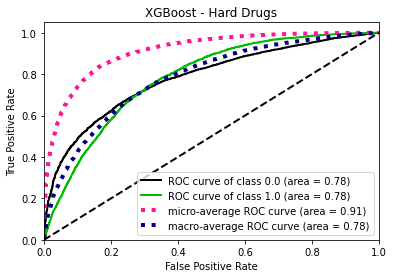

In [36]:
scikitplot.metrics.plot_roc(yTest, xgb_hard_probs, title = "XGBoost - Hard Drugs")
plt.show()

In [37]:
from sklearn.metrics import classification_report
print(classification_report(yTest, xgb_hard_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.98      0.91     17108
         1.0       0.50      0.12      0.20      3371

    accuracy                           0.84     20479
   macro avg       0.68      0.55      0.55     20479
weighted avg       0.79      0.84      0.79     20479



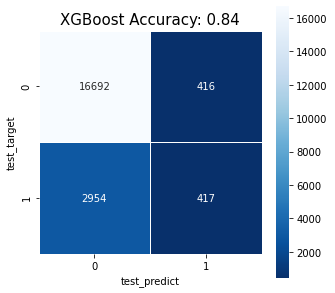

In [38]:
x = metrics.confusion_matrix(yTest, xgb_hard_pred)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
plt.figure(figsize=(5,5))
sns.heatmap(x, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues_r');
plt.ylabel('test_target');
plt.xlabel('test_predict');
title = 'XGBoost Accuracy: {:.2f}'.format(xgb_hard_score)
plt.title(title, size = 15);

# Model Selection

In [39]:
print('Logistic Regression Score:', logreg_hard_score)
print('Random Forest Score:',rfc_hard_score)
print('XGBoost:',xgb_hard_score)

Logistic Regression Score: 0.8383710142096782
Random Forest Score: 0.8190829630353045
XGBoost: 0.8354411836515455


While the logistic regression has a slightly better score, XGBoost outperforms it in AUC.  

# Feature Significance / Importance

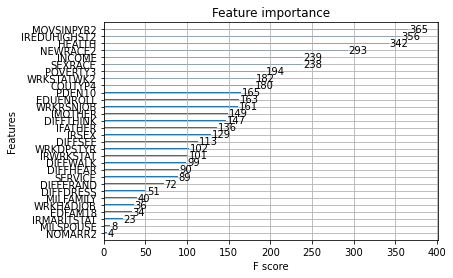

In [40]:
#chi2, p = feature_selection.chi2(xTrain,yTrain)

#g12_feat = pd.DataFrame(columns = ['Features'])

#g12_feat['Features'] = cols
#g12_feat['p-val'] = p
#g12_feat['Importance']=xgb_hard.feature_importances_
#g12_feat.sort_values('Importance',inplace = True,ascending=False)
#print(g12_feat)

#features = pd.DataFrame()
#features['features'] = cols
#features['importance'] = logreg_hard.coef_[0]

#features.sort_values('importance', inplace = True)

#print(features)

from xgboost import plot_importance

#plt.rcParams["figure.figsize"] = (10,10)
plot_importance(xgb_hard)
plt.show()

# Cohort 2

In [51]:
xTrain, xTest, yTrain, yTest = train_test_split(df_g3[cols], df_g3['hard_drug_flag'], test_size = .3)

rfc_hard = RandomForestClassifier(n_estimators = 100, random_state = 0)
rfc_hard.fit(xTrain,yTrain)
rfc_hard_pred = rfc_hard.predict(xTest)
rfc_hard_probs = rfc_hard.predict_proba(xTest)
rfc_hard_score = rfc_hard.score(xTest,yTest)

logreg_hard = LogisticRegression(random_state=0,max_iter=1000)
logreg_hard.fit(xTrain,yTrain)
logreg_hard_pred = logreg_hard.predict(xTest)
logreg_hard_probs = logreg_hard.predict_proba(xTest)
logreg_hard_score = logreg_hard.score(xTest,yTest)

xgb_hard = xgb.XGBClassifier()
xgb_hard.fit(xTrain, yTrain)
xgb_hard_pred = xgb_hard.predict(xTest)
xgb_hard_probs = xgb_hard.predict_proba(xTest)
xgb_hard_score = xgb_hard.score(xTest,yTest)



/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:53:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


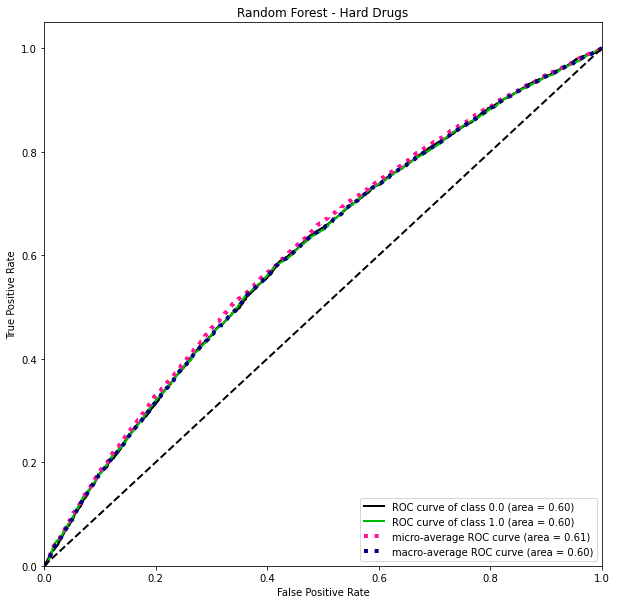

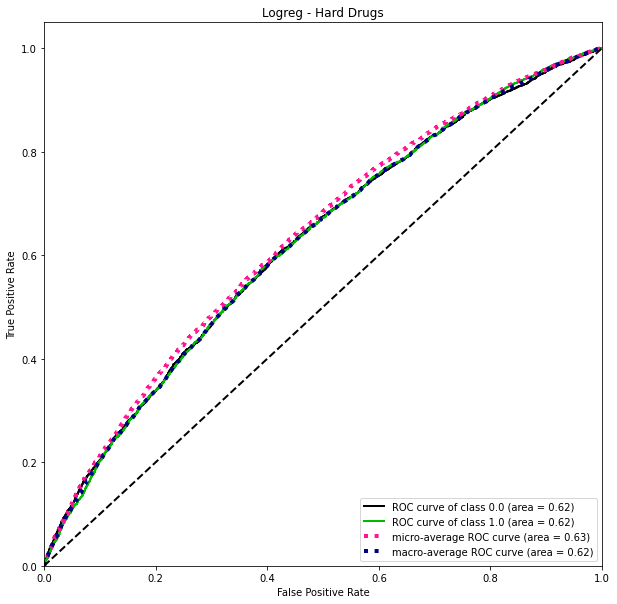

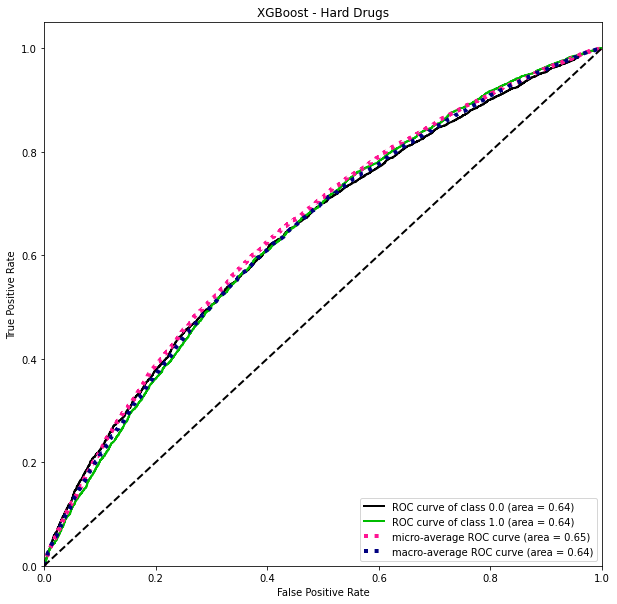

In [52]:

scikitplot.metrics.plot_roc(yTest, rfc_hard_probs, title = 'Random Forest - Hard Drugs')
scikitplot.metrics.plot_roc(yTest, logreg_hard_probs, title = 'Logreg - Hard Drugs')
scikitplot.metrics.plot_roc(yTest, xgb_hard_probs, title = 'XGBoost - Hard Drugs')
plt.show()

In [53]:
from sklearn.metrics import classification_report
print(classification_report(yTest, rfc_hard_pred))
print(classification_report(yTest, logreg_hard_pred))
print(classification_report(yTest, xgb_hard_pred))

              precision    recall  f1-score   support

         0.0       0.54      0.51      0.52      4586
         1.0       0.61      0.64      0.63      5536

    accuracy                           0.58     10122
   macro avg       0.58      0.58      0.58     10122
weighted avg       0.58      0.58      0.58     10122

              precision    recall  f1-score   support

         0.0       0.57      0.43      0.49      4586
         1.0       0.61      0.73      0.66      5536

    accuracy                           0.59     10122
   macro avg       0.59      0.58      0.58     10122
weighted avg       0.59      0.59      0.58     10122

              precision    recall  f1-score   support

         0.0       0.59      0.47      0.53      4586
         1.0       0.63      0.73      0.67      5536

    accuracy                           0.61     10122
   macro avg       0.61      0.60      0.60     10122
weighted avg       0.61      0.61      0.61     10122



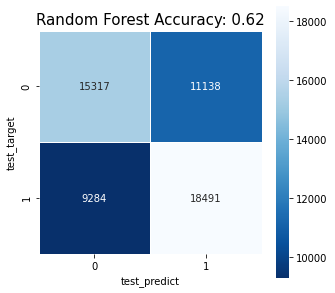

In [44]:
x = metrics.confusion_matrix(yTest, rfc_hard_pred)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
plt.figure(figsize=(5,5))
sns.heatmap(x, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues_r');
plt.ylabel('test_target');
plt.xlabel('test_predict');
title = 'Random Forest Accuracy: {:.2f}'.format(rfc_hard_score)
plt.title(title, size = 15);

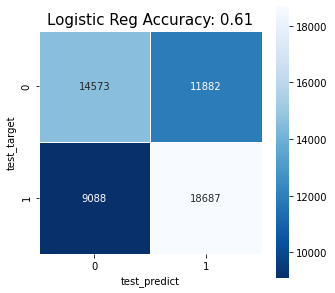

In [45]:
x = metrics.confusion_matrix(yTest, logreg_hard_pred)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
plt.figure(figsize=(5,5))
sns.heatmap(x, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues_r');
plt.ylabel('test_target');
plt.xlabel('test_predict');
title = 'Logistic Reg Accuracy: {:.2f}'.format(logreg_hard_score)
plt.title(title, size = 15);

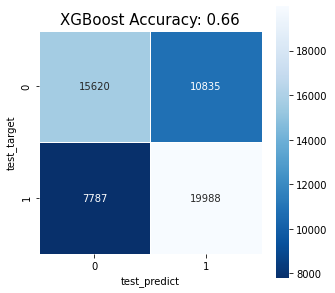

In [46]:
x = metrics.confusion_matrix(yTest, xgb_hard_pred)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
plt.figure(figsize=(5,5))
sns.heatmap(x, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues_r');
plt.ylabel('test_target');
plt.xlabel('test_predict');
title = 'XGBoost Accuracy: {:.2f}'.format(xgb_hard_score)
plt.title(title, size = 15);

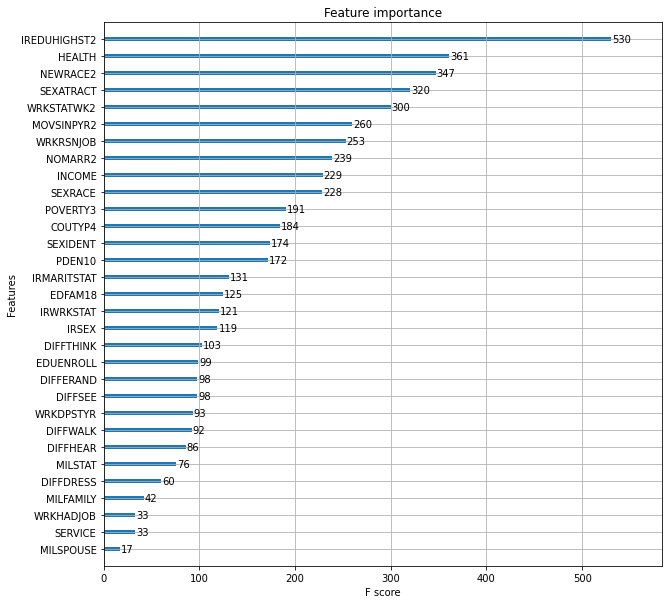

In [47]:
from xgboost import plot_importance

plt.rcParams["figure.figsize"] = (10,10)
plot_importance(xgb_hard)
plt.show()

# Cohort 3

In [55]:
xTrain, xTest, yTrain, yTest = train_test_split(df_g45[cols], df_g45['hard_drug_flag'], test_size = .8)

rfc_hard = RandomForestClassifier(n_estimators = 100, random_state = 0)
rfc_hard.fit(xTrain,yTrain)
rfc_hard_pred = rfc_hard.predict(xTest)
rfc_hard_probs = rfc_hard.predict_proba(xTest)
rfc_hard_score = rfc_hard.score(xTest,yTest)

logreg_hard = LogisticRegression(random_state=0,max_iter=1000)
logreg_hard.fit(xTrain,yTrain)
logreg_hard_pred = logreg_hard.predict(xTest)
logreg_hard_probs = logreg_hard.predict_proba(xTest)
logreg_hard_score = logreg_hard.score(xTest,yTest)

xgb_hard = xgb.XGBClassifier()
xgb_hard.fit(xTrain, yTrain)
xgb_hard_pred = xgb_hard.predict(xTest)
xgb_hard_probs = xgb_hard.predict_proba(xTest)
xgb_hard_score = xgb_hard.score(xTest,yTest)

/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:55:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


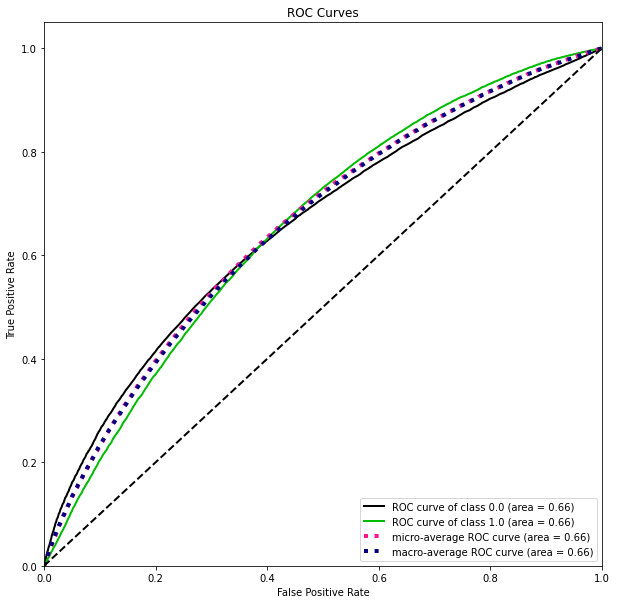

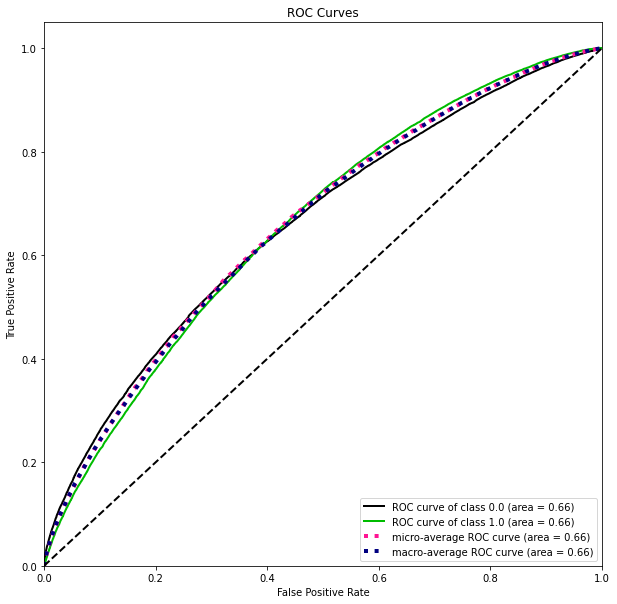

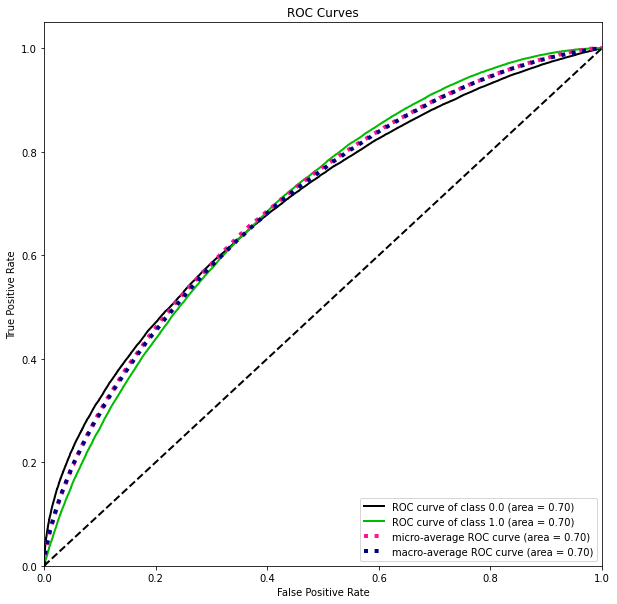

In [49]:

scikitplot.metrics.plot_roc(yTest, rfc_hard_probs)
scikitplot.metrics.plot_roc(yTest, logreg_hard_probs)
scikitplot.metrics.plot_roc(yTest, xgb_hard_probs)
plt.show()

In [54]:
from sklearn.metrics import classification_report
print(classification_report(yTest, rfc_hard_pred))
print(classification_report(yTest, logreg_hard_pred))
print(classification_report(yTest, xgb_hard_pred))

              precision    recall  f1-score   support

         0.0       0.54      0.51      0.52      4586
         1.0       0.61      0.64      0.63      5536

    accuracy                           0.58     10122
   macro avg       0.58      0.58      0.58     10122
weighted avg       0.58      0.58      0.58     10122

              precision    recall  f1-score   support

         0.0       0.57      0.43      0.49      4586
         1.0       0.61      0.73      0.66      5536

    accuracy                           0.59     10122
   macro avg       0.59      0.58      0.58     10122
weighted avg       0.59      0.59      0.58     10122

              precision    recall  f1-score   support

         0.0       0.59      0.47      0.53      4586
         1.0       0.63      0.73      0.67      5536

    accuracy                           0.61     10122
   macro avg       0.61      0.60      0.60     10122
weighted avg       0.61      0.61      0.61     10122



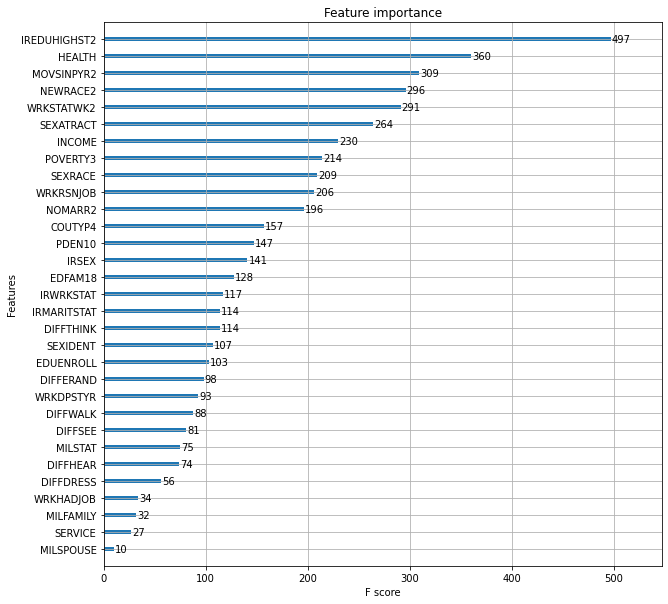

In [56]:
plt.rcParams["figure.figsize"] = (10,10)
plot_importance(xgb_hard)
plt.show()

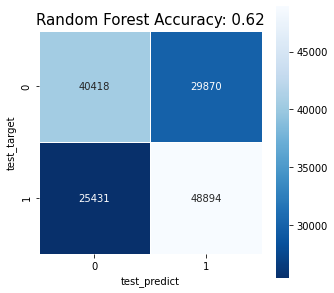

In [57]:
x = metrics.confusion_matrix(yTest, rfc_hard_pred)

plt.figure(figsize=(5,5))
sns.heatmap(x, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues_r');
plt.ylabel('test_target');
plt.xlabel('test_predict');
title = 'Random Forest Accuracy: {:.2f}'.format(rfc_hard_score)
plt.title(title, size = 15);

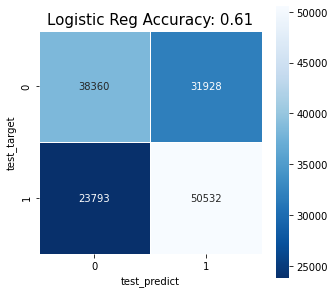

In [58]:
x = metrics.confusion_matrix(yTest, logreg_hard_pred)

plt.figure(figsize=(5,5))
sns.heatmap(x, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues_r');
plt.ylabel('test_target');
plt.xlabel('test_predict');
title = 'Logistic Reg Accuracy: {:.2f}'.format(logreg_hard_score)
plt.title(title, size = 15);

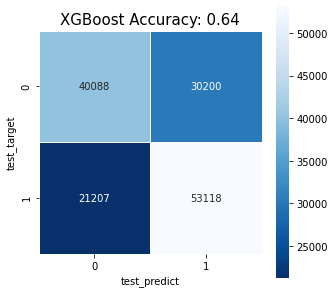

In [59]:
x = metrics.confusion_matrix(yTest, xgb_hard_pred)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
plt.figure(figsize=(5,5))
sns.heatmap(x, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues_r');
plt.ylabel('test_target');
plt.xlabel('test_predict');
title = 'XGBoost Accuracy: {:.2f}'.format(xgb_hard_score)
plt.title(title, size = 15);